**TODO:**

- 3-5 CNN models
- From simple 1 layer fully connected to transfer learning
- May review ensemble
- Need to review books vs movies(tvshows) model

In [1]:
import keras
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from matplotlib import pyplot as plt
import time
import helper_keras
import numpy as np
import pandas as pd
import os

/home/jason/anaconda3/envs/goodscifi/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


#### Data Paths

In [4]:
notbook_path = '/home/jason/DeepLearning/github/goodscifi/development/notebooks/'
home_path = '/home/jason/DeepLearning/github/goodscifi/development/'
data_path = '/home/jason/DeepLearning/github/goodscifi/development/data/'
model_path = '/home/jason/DeepLearning/github/goodscifi/development/models/'

In [5]:
# Not using 'sample' since I have less than 6k total data
training_data = data_path+'dataset/books/train_undersample/'
validation_data = data_path+'dataset/books/valid_undersample/'

#### Input Data

In [ ]:
train_batches = helper_keras.get_batches(training_data) # update target_size
val_batches = helper_keras.get_batches(validation_data)

In [ ]:
# Create numpy array of data
train_data_array = helper_keras.get_data(training_data)
val_data_array = helper_keras.get_data(validation_data)

In [ ]:
# Save and use for datagen.fit
helper_keras.save_array(data_path+'dataset/books/train_data.bcolz',train_data_array)
helper_keras.save_array(data_path+'dataset/books/val_data.bcolz',val_data_array)

#### Load Data Array

In [ ]:
train_data_array = helper_keras.load_array(data_path+'dataset/books/train_data.bcolz')
val_data_array = helper_keras.load_array(data_path+'dataset/books/val_data.bcolz')

#### Data Augmentation

In [ ]:
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     rescale=1./255,)

image_datagen = ImageDataGenerator(**data_gen_args)

In [ ]:
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(train_data_array, augment=True, seed=seed)

In [ ]:
# Use this to standardize images for prediction
image_datagen.standardize?

In [ ]:
# Get train_batches with datagen augmentation (normalized)
# update target_size and batch_size

# update 'get_batches' with seed
train_batches_aug = helper_keras.get_batches(training_data,
                                           gen=image_datagen, 
                                           batch_size=8,
                                           target_size=(150,150)) 
val_batches_aug = helper_keras.get_batches(validation_data,
                                         gen=image_datagen, 
                                         batch_size=8,
                                         target_size=(150,150))

In [ ]:
# Set input_shape for all models
input_shape = train_batches_aug.image_shape; input_shape

In [ ]:
# Set steps per epoch for train & validation data
steps_per_epoch = train_batches_aug.samples/train_batches_aug.batch_size
val_steps = val_batches_aug.samples/val_batches_aug.batch_size

print('steps per epoch:', steps_per_epoch)
print('validation steps:', val_steps)

#### Fully Connected NN

In [ ]:
import nn_dense
model = nn_dense.model(input_shape)
model.summary()

#### Simple CNN

In [ ]:
import nn_simple
model = nn_simple.model(input_shape)
model.summary()

#### Deep CNN

In [ ]:
import nn_deep
import nn_deep_sep_conv
import nn_mobilenet
import nn_squeezenet

#### Test Model Parameters

In [ ]:
# Import the SGD optimizer
from keras.optimizers import SGD

lr_to_test = [0.001, 0.0001, 0.00001]
alpha = 2
model_history = []

# Loop over learning rates
for lr in lr_to_test:
    print('\n\nTesting model with lr parameter: %f\n'%lr )
    
    # Build new model to test, unaffected by previous models
    model = nn_squeezenet.SqueezeNet(input_shape=input_shape)
    
    # Create SGD optimizer with specified learning rate: my_optimizer
    # Use SGD rather than Adam to help narrow down best learning rate to start with
    my_optimizer = SGD(lr=lr)
    
    # Compile the model
    model.compile(optimizer=my_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    # Fit the model
    model_history.append(
                            model.fit_generator(
                                    train_batches_aug, 
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=val_batches_aug,
                                    validation_steps=val_steps,
                                    epochs=30,
                                    verbose=0)
                        )

In [ ]:
helper_keras.plot_model_history(model_history[0])

**Run Time**

In [ ]:
import nn_mobilenet

In [ ]:
# Learning rate at 0.001 with alpha 2, using SGD

# Alpha / width
alpha = 1

# Create model
model = nn_mobilenet.model(alpha=alpha, input_shape=input_shape, shallow=True)

# Optimizer
optimizer = Adam(lr=0.00001)

# Compile the model
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

# Checkpoint callback
outputFolder = model_path+'nn_mobilenet/'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=True)

# Darly stopping callback
earlystop = EarlyStopping(monitor='val_loss', patience=5,verbose=1, mode='auto')

callbacks_list = [checkpoint, earlystop]


# Fit the model
start = time.time()
print("Model started training at",time.ctime())
history =  model.fit_generator(train_batches_aug,
                               steps_per_epoch=steps_per_epoch,
                               validation_data=val_batches_aug,
                               validation_steps=val_steps,
                               epochs=50,
                               verbose=0,
                               callbacks=callbacks_list)
end = time.time()
print("Model took %0.2f seconds to train"%(end - start))
# plot model history
helper_keras.plot_model_history(history)

In [ ]:
helper_keras.plot_model_history(history) #Adam: lr = 0.00001, swallow=True, alpha=1

In [ ]:
helper_keras.plot_model_history(history) #SGD: lr = 0.00001, swallow=True, alpha=1

**SqueezeNet**

In [ ]:
import nn_squeezenet

In [ ]:
# Create model
model = nn_squeezenet.SqueezeNet(input_shape=input_shape, classes=2)

# Optimizer
optimizer = Adam(lr=0.0006)

# Compile the model
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

# Checkpoint callback
outputFolder = model_path+'nn_squeezenet/'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=True)

# Darly stopping callback
earlystop = EarlyStopping(monitor='val_loss', patience=5,verbose=1, mode='auto')

callbacks_list = [checkpoint, earlystop]


# Fit the model
start = time.time()
print("Model started training at",time.ctime())
history =  model.fit_generator(train_batches_aug,
                               steps_per_epoch=steps_per_epoch,
                               validation_data=val_batches_aug,
                               validation_steps=val_steps,
                               epochs=50,
                               verbose=0,
                               callbacks=callbacks_list)
end = time.time()
print("Model took %0.2f seconds to train"%(end - start))
# plot model history
helper_keras.plot_model_history(history)

In [ ]:
#SqueezeNet - Adam: lr = 0.0006
#SqueezeNet - SGD: lr = 0.00001

**Transfer Learning & Fine Tuning**

In [ ]:
# https://deeplearningsandbox.com/how-to-use-transfer-learning-and-fine-tuning-in-keras-and-tensorflow-to-build-an-image-recognition-94b0b02444f2
# https://flyyufelix.github.io/2016/10/08/fine-tuning-in-keras-part2.html

In [ ]:
# Feature Extraction (do later)
# 1. Get lower level model layer
# 2. Build last layer (a. Dense layer and b. FC layer)
# 3. Create new model
# 4. Train and review history

In [6]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
# from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, \
    BatchNormalization, Activation, Dropout

In [7]:
# from Keras github - 4D tensor required for VGG19 on imagenet dataset
def preprocess_image(img):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [54]:
# TODO: Flatten vs GlobalAveragePooling2D() in this context
def add_dense_last_layer(base_model, fc_units=1024, classes=2):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(fc_units)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    predictions = Dense(classes, activation='softmax')(x) 
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [ ]:
# TODO: Look into full convolutional nn
# def add_fully_conv_last_layer(base_model, classes=2):
#     x = base_model.output
#     x = BatchNormalization()(x)
#     x = Conv2D(1024, activation='relu')(x) 
#     predictions = Dense(classes, activation='softmax')(x) 
#     model = Model(inputs=base_model.input, outputs=predictions)
#     return model

In [9]:
def freeze_and_compile(base_model, model, optimizer):
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
def create_callbacks():
    outputFolder = model_path+'nn_inception/'
    if not os.path.exists(outputFolder):
        os.makedirs(outputFolder)
    filepath=outputFolder+"weights.best.hdf5"
    
    # Checkpoint callback
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                                 save_best_only=True, save_weights_only=True)

    # Early stopping callback
    earlystop = EarlyStopping(monitor='val_loss', patience=5,verbose=1, mode='auto')
    
    return [checkpoint, earlystop]

Data

In [11]:
# Image Preprocessing and data augmentation
image_gen = ImageDataGenerator(
                                preprocessing_function=preprocess_input,
#                                 width_shift_range=0.2,
#                                 height_shift_range=0.2,
#                                 shear_range=0.2,
#                                 zoom_range=0.2
                            )

In [12]:
train_batches_aug = helper_keras.get_batches(training_data,
                                            gen=image_gen, 
                                            batch_size=16,
                                            target_size=(150,150)) 
val_batches_aug = helper_keras.get_batches(validation_data,
                                            gen=image_gen, 
                                            batch_size=16,
                                            target_size=(150,150))

Found 2618 images belonging to 2 classes.
Found 972 images belonging to 2 classes.


In [13]:
# Set input_shape for all models
input_shape = train_batches_aug.image_shape; input_shape

(150, 150, 3)

In [14]:
# Set steps per epoch for train & validation data
steps_per_epoch = train_batches_aug.samples/train_batches_aug.batch_size
val_steps = val_batches_aug.samples/val_batches_aug.batch_size

print('steps per epoch:', steps_per_epoch)
print('validation steps:', val_steps)

steps per epoch: 163.625
validation steps: 60.75


In [15]:
# Imblanced data (1114, 7054) (good, not_good)
# https://stackoverflow.com/a/42587192/1343001
from collections import Counter
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(training_data)

counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     
class_weights

Found 2618 images belonging to 2 classes.


{0: 3.592982456140351, 1: 1.0}

Training

In [ ]:
# "vastly" different content to imagenet (book covers)
# need to use lower level features of model
# base_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)

In [16]:
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model = Model(inputs=base_model.input, outputs=base_model.output)
# base_model.summary()



Testing model with lr parameter: 0.000100

Model started training at Wed Jul 12 22:20:15 2017
Model took 1664.69 seconds to train


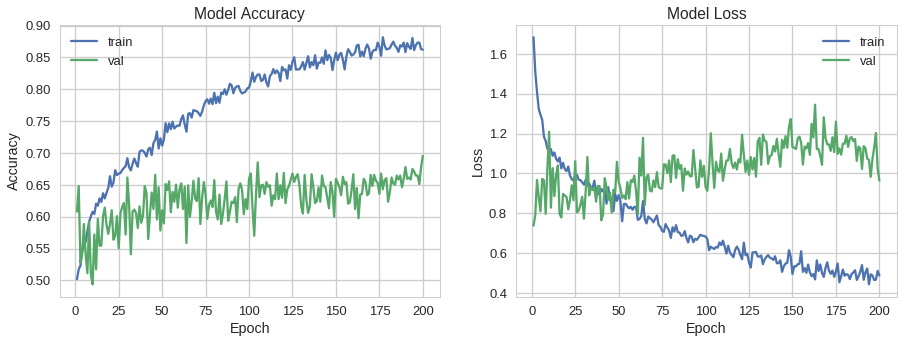

In [55]:
lr_to_test = [0.0001]
# model_history = []
cls_weight = {0:4, 1:1}

# Loop over learning rates
for lr in lr_to_test:
    print('\n\nTesting model with lr parameter: %f\n'%lr )
    # Create new model
    model = add_dense_last_layer(base_model)
    
    # Optimizer
    # Use SGD to start - find the best appropriate lr for Adam
    optimizer = Adam(lr=lr)
    
    # Compile 
    freeze_and_compile(base_model, model, optimizer)
    callbacks_list = create_callbacks()

    # Fit the model
    start = time.time()
    print("Model started training at",time.ctime())
    history =  model.fit_generator(train_batches_aug,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=val_batches_aug,
                                    validation_steps=val_steps,
                                    epochs=200,
                                    verbose=0,
#                                     callbacks=callbacks_list,
                                    class_weight=cls_weight)
    end = time.time()
    print("Model took %0.2f seconds to train"%(end - start))
    # plot model history
    helper_keras.plot_model_history(history)

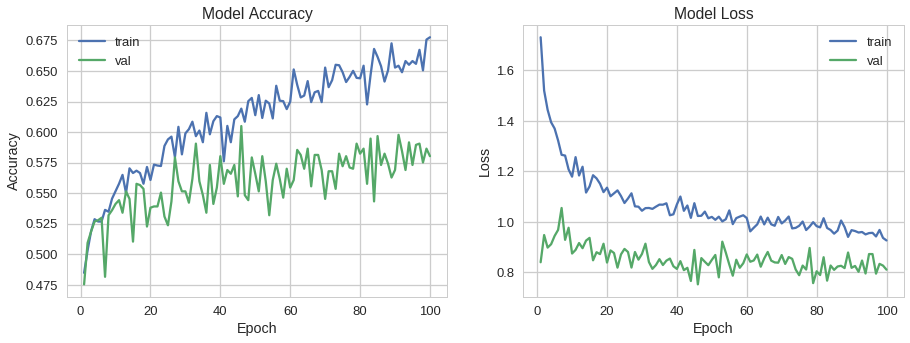

In [46]:
helper_keras.plot_model_history(history) # Dropout 0.8, lr=0.000100, SGD, momentum=0.8

In [ ]:
model.save(model_path+'/inception_dl.h5')

In [ ]:
# Review ROC / F1 